#Probabilistic Numerical Method of Lines (PNMOL)


[Probabilistic Numerical Method of Lines for Time-Dependent Partial Differential Equations](https://arxiv.org/abs/2110.11847) by Krämer, Hennig & Schmidt (2022):

A probabilistic PDE solver based on the method of lines. It discretizes space while keeping track of the resulting discretization
error and then feeds that into a probabilistic ODE solver. This method leads to better-calibrated uncertainty estimates and enables flexible spatial grids and seamless integration with probabilistic solvers.

## Method of Lines

The Method of Lines (MOL) is a numerical approach for solving partial differential equations (PDEs) by discretizing the spatial domain into grid points while keeping time continuous. This transforms the PDE into a system of ordinary differential equations (ODEs), which can be solved using standard time-integration methods.

In other words we discretize space while disregarding the discretization error, and then feed that into a (possibly) probabilistic ODE solver. PNMOL additionally keeps track of the discretization error and combines it with that from the solver, enabling more precise uncertainty estimates.

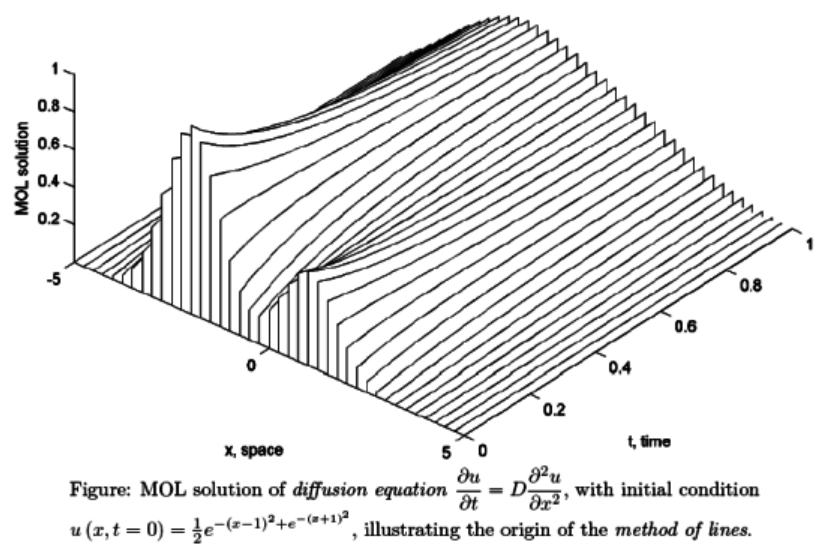

[*A Compendium of Partial Differential Equation Models
Method of Lines Analysis with Matlab
William E Schiesser • Graham W Griffiths
(Cambridge University Press, ISBN-13: 978-0-521-51986-1)*](https://pdecomp.net/TheCompendium/chap01.php)

## Rothe’s method vs Method of Lines

There are two ways to numerically solve a PDE that has time
and space dimensions: You can first discretize time and then space (Rothe’s method) or
you can first discretize space, which leads to an ODE that may then be tackled by an
ODE solver (Method of Lines).
With Rothe's method we obtain one PDE per time step and discretize the spatial dimension in each time step seperately.

With the method of lines we use ODE solvers to discretize the time dimension in the second step.

If the spatial mesh is fixed, both approaches lead to the same solution.

$
\begin{array}{|l|l|l|}
\hline
\text{Method} & \textbf{Rothe's Method} & \textbf{MOL} \\
\hline
\text{Advantages} &
\begin{array}{l}
\text{More flexible: change the spatial mesh between time steps} \\
\text{Higher stability: implicit time discretization schemes}
\end{array} &
\begin{array}{l}
\text{Wide choice of solvers: adaptive or higher-order ODE solvers} \\
\text{Probabilistic solvers: enables probabilistic ODE solvers}
\end{array} \\
\hline
\text{Disadvantages} & \text{requires solving PDE at every time step} &
\text{ODE system may be stiff, so solver must be chosen carefully} \\
\hline
\end{array}$



## Why can't we simply discretize space and then directly apply a probabilistic ODE solver to the resulting ODE?

Then the uncertainty resulting from discretization is not taken into account and the model is more certain than it should be:
*   differentiation matrix $D$ only approximates the true differential operator $\mathcal{D}$ $⇒$ introduces an error in the spatial derivatives
*   ODE solver assumes that $D$ is exact and is only aware of time-discretization errors $⇒$ underestimates the total uncertainty
*   if the spatial grid is too coarse, the spatial discretization error dominates, even if the ODE solver is very accurate

PNMOL solves this problem: it combines the probabilistic discretisation with an ODE Filter. Other than non-probabilistic MOL, this
combination quantifies the leak of information between
the space discretisation and the ODE solution. This can be seen below in Figure 1 from the paper:






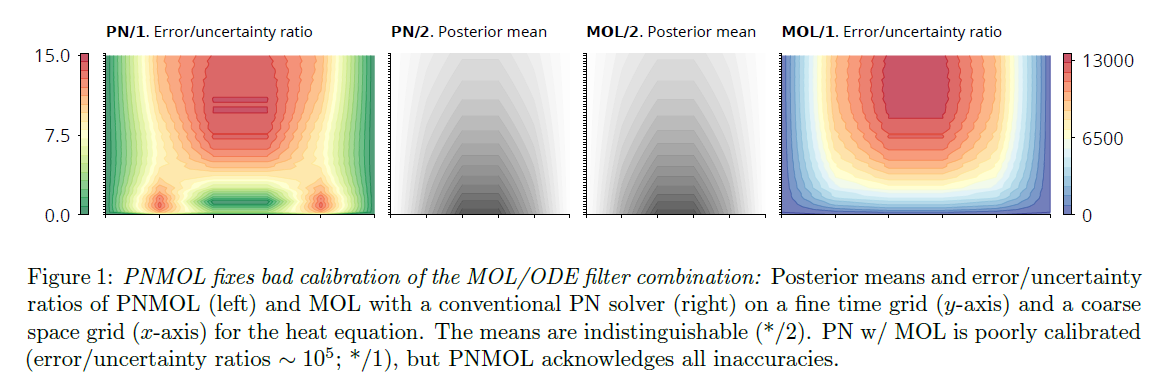

## Tracking of the spatial discretization error

The autors use a probabilistic discretization of space, which explicitly models the uncertainty in spatial derivatives. Instead of approximating the differential operator $\mathcal{D}$ with a fixed matrix $D$, we treat it probabilistically:

$$
(\mathcal{D} u_x)(\mathbb{X}) = D u_x(\mathbb{X}) + \xi_x(\mathbb{X}),
$$

where:
- $D$ is the differentiation matrix
- $ \xi_x \sim \mathcal{N}(0, \gamma^2 E) $ represents the uncertainty in the spatial discretization

The matrix $E = \hat{k}(\mathbb{X},\mathbb{X})$ quantifies the discretization error introduced by approximating $\mathcal{D} u(x)$ using $D u(X)$. Thus, the differentiation operator itself is uncertain, leading to a latent force model in the ODE system.

The probabilistic ODE solver now has information about spatial errors and can propagate this uncertainty over time, which leads to better-calibrated uncertainty estimates.

The spatial discretisation error being part of the probabilistic model is the advantage of PNMOL over non-probabilistic versions.

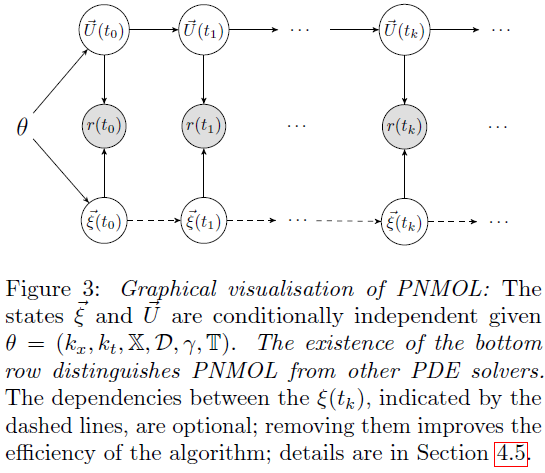

### Step-by-step derivation:

Gaussian process prior: $ u_x \sim GP(0, k_x) $

Want: $\mathcal{D} u_x (\mathbb{X})$(
evaluate GP on datapoints after applying differential opperator $\mathcal{D}$)

Know: $u_x ~ (\mathbb{X}) \sim \mathcal{N}(y, "0")$

Use properties of GPs:

$u_x | (u_x(\mathbb{X}) = y) \sim GP (0+k_x(\cdot, \mathbb{X}) k_x(\mathbb{X}, \mathbb{X})^{-1}(y-0), k_x (\cdot,\cdot^{\prime}) - k_x(\cdot, \mathbb{X}) k_x(\mathbb{X}, \mathbb{X})^{-1} k_x (\mathbb{X},{\cdot}^{\prime}))$

$\mathcal{D} u_x | (u_x(\mathbb{X}) = y) \sim GP(\mathcal{D} k_x(\cdot, \mathbb{X}) k_x(\mathbb{X}, \mathbb{X})^{-1} y, \mathcal{D} k_x \mathcal{D}^{\prime}(\cdot, \cdot^{\prime})-\mathcal{D} k_x(\cdot, \mathbb{X}) k_x(\mathbb{X}, \mathbb{X})^{-1} k_x\mathcal{D}^{\prime}(\mathbb{X}, \cdot))$



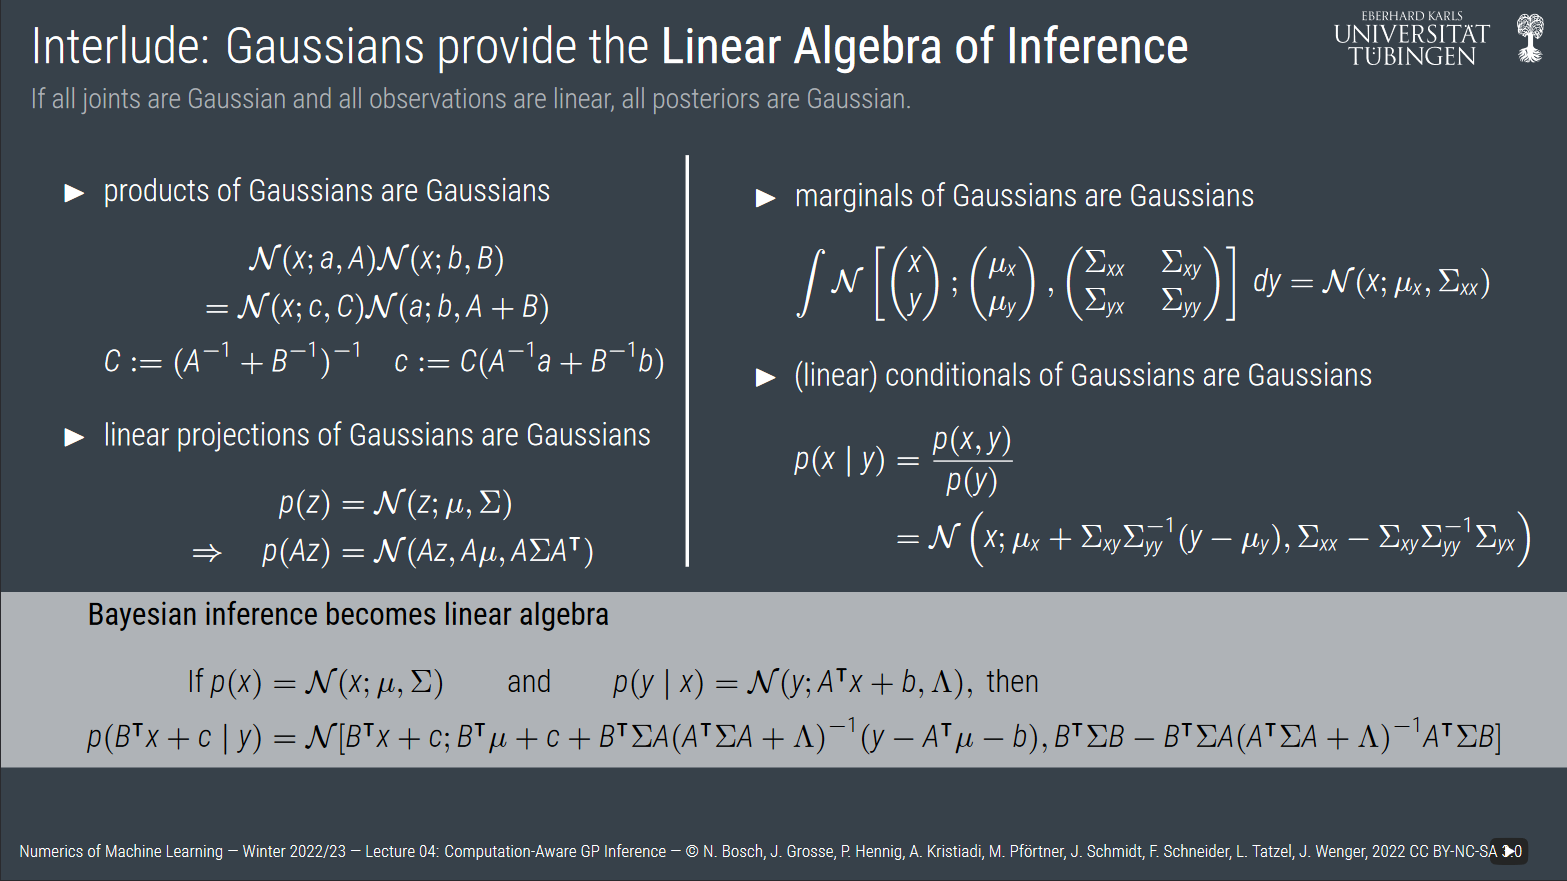

Then we evaluate $\mathcal{D} u_x | (u_x(\mathbb{X}) = y) (\mathbb{X}) \sim \mathcal{N}(D u_x(\mathbb{X}), \gamma^2 E) $

## Efficient treatment of the derivative matrix

The key trick used by the authors for efficiently handling the derivative matrix $D$ is the localized differentiation matrix, also known as probabilistic numerical finite differences. We only consider local influence from neighboring grid points:
  - select a local stencil around each point $x_n$:
  $$x_{\text{loc($n$)}} = \{x_{n-k},...,x_n,...,x_{n+k}\}$$
  - approximate the derivative at each point $x_n$ individually
  - row-by-row assembly of differentiation matrix $D$
  $$d_n=\left(\mathcal{D} k_x\right)\left(x_n, x_{\operatorname{loc}(n)}\right) k_x\left(x_{\operatorname{loc}(n)}, x_{\operatorname{loc}(n)}\right)^{-1}$$
  - can be sparsified naturally wihout losing discretization or differentiation uncertainty
  - corresponds to the Finite Difference Method

Using this trick improves computational efficiency and scalability.

## Spatiotemporal prior construction

The spatiotemporal prior in PNMOL is a Gaussian process prior that models uncertainty over both space and time. The key idea is to construct a global prior that captures the correlation structure in both dimensions and doesn't treat them separately as in classical MOL.

The function $ u(t, x) $ is modeled as a separable Gaussian process:

$$
u(t, x) \sim GP(0, \gamma^2 k_t(t, t') \otimes k_x(x, x'))
$$

where:
- $ k_t(t, t') $ is the temporal covariance kernel (e.g. an integrated Wiener process or a Matérn kernel)
- $ k_x(x, x') $ is the spatial covariance kernel (e.g. squared exponential or RBF kernel)
- $ \gamma^2 $ is an output scale parameter
- $ \otimes $ denotes the Kronecker (tensor) product, ensuring separability

### Why a separable Prior?
- Enables efficient inference by simplifying the structure of the covariance
- state-space formulation: The temporal kernel is rewritten as a linear, time-invariant stochastic differential equation (SDE)
  - e.g. integrated Wiener process or the Matérn process
  - temporal kernel for computation benefit, kernel must be separable but starts with single GP
  - enables efficient Kalman filter + smoothing computation
  - computation time of $O(n)$ or even $O(log(n))$ for grid size $n$
- probabilistic discretization of spatial derivatives means that uncertainty in $ D u_x(X) $ is explicitly modeled
- joint uncertainty propagation: final model tracks both function evolution and spatial errors

By combining the temporal SDE and the spatial discretization, we get a joint state-space model. This leads to a filtering-based probabilistic solver, where both function values and spatial discretization errors are inferred jointly.

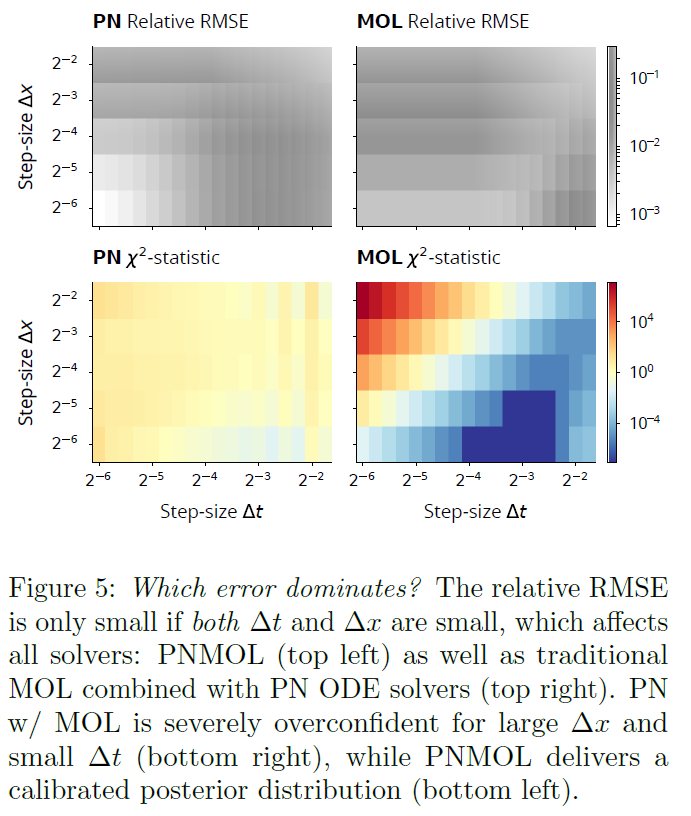

## White Noise Approximation

While the latent force model provides a structured and correlated treatment of spatial discretization error, it introduces additional computational complexity by expanding the state space. To reduce computational cost while still capturing some uncertainty, the autors use white noise approximation.

Spatial errors may be effectively modeled as **independent at each time step** by replacing the structured latent process with **uncorrelated Gaussian noise**:
$$
\xi(t) \sim \mathcal{N}(0, \gamma^2 E)
$$

where:
- $ \xi(t)$vpresents the spatial discretization error at time $ t$
- $ E $ is the covariance structure from the spatial discretization process
- $ \gamma^2$ scales the magnitude of the noise

## latent PNMOL vs white noise PNMOL vs MOL

\begin{array}{|l|l|l|l|}
\hline
\textbf{Feature} & \textbf{Latent Force Model} & \textbf{White Noise Model} & \textbf{Standard MOL} \\
\hline
\textbf{Spatial Error Modeling} &
\text{Tracks spatial error as a latent process over time} &
\text{Assumes independent noise at each time step} &
\text{Ignores spatial discretization error} \\
\hline
\textbf{Uncertainty Estimation} &
\text{Best: Accounts for correlated errors} &
\text{Moderate: Ignores error accumulation} &
\text{Poor: Overconfident, assumes exact spatial derivatives} \\
\hline
\textbf{Computational Cost} &
\text{Higher: Tracks extra state variables} &
\text{Lower: No extra state variables} &
\text{Lowest: No probabilistic correction} \\
\hline
\end{array}


## Hyperparameters

### Kernels
- Prior: temporal integrated Wiener process
  - commonly found in probabilistic ODE solvers
- Order of integration: $ \nu \in \{1, 2\} $
  - alignes with standard low-order ODE solvers
- Kernel: squared exponential kernel
  - smooth approximations
  - spatial kernels must be sufficiently differentiable for closed-form differentiation
  - rational quadratic or Matérn kernels would also work
- Input scale: $ r = 3.2 $
  - how strongly neighboring points influence each other
- Output scale: $ \gamma \in \{0.01, 0.1\} $
  - controls the width of the posterior distribution and influences how uncertainty is quantified
  - estimated using quasi-maximum likelihood estimation (MLE)

### Spatial Grid
- equispaced grids used for simplicity
- the grid points for discretization do not need to be connected
- spatial point could be freely scattered
- stencil size (number of neighboring points used for approximations) is small to improve stability

## Burger's Equation:

Burgers' equation is a fundamental partial differential equation used in fluid dynamics, traffic flow, and nonlinear wave theory:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

#### **Parameters:**
- $u(x,t)$: Velocity field (solution of the equation)
- $t$: Time
- $x$: Spatial coordinate
- $\nu$: **Viscosity (diffusion coefficient)**  
  - $\nu > 0$: **Viscous Burgers' equation** (includes diffusion)  
  - $\nu = 0$: **Inviscid Burgers' equation** (forms shock waves)
- $\frac{\partial u}{\partial t}$: Rate of change of velocity.
- $u \frac{\partial u}{\partial x}$: **Nonlinear convection term** (causes wave steepening)
- $\nu \frac{\partial^2 u}{\partial x^2}$: **Diffusion term** (smooths out gradients)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

nx = 25
Lx = 2.0
dx = Lx / (nx - 1)
x = np.linspace(0, Lx, nx)

# Initial condition: Step function (shock formation)
def initial_condition(x):
    u0 = np.ones_like(x)
    u0[(x >= 0.5) & (x <= 1)] = 2  # Initial shock
    return u0

def burgers_equation(nu, t_max):
    u = initial_condition(x)
    num_steps = int(t_max / 0.01)  # Set time steps
    for _ in range(num_steps):
        dt = 0.1 * dx / np.max(np.abs(u))  # Apply CFL condition
        u_next = u.copy()
        u_next[1:-1] = u[1:-1] - dt / dx * (u[1:-1] * (u[1:-1] - u[:-2]))  # Upwind scheme
        u_next[1:-1] += nu * dt / dx**2 * (u[2:] - 2 * u[1:-1] + u[:-2])  # Diffusion
        u = u_next
    return u

def update_plot(nu=0.1, t_max=1.0):
    u = burgers_equation(nu, t_max)
    plt.figure(figsize=(6, 4))
    plt.plot(x, u, label=f'ν = {nu}, t = {t_max}', color="blue")
    plt.xlabel("x")
    plt.ylabel("u(x, t)")
    plt.title("Interactive Burgers' Equation Solution")
    plt.legend()
    plt.grid()
    plt.ylim(0, 2.5)
    plt.show()

nu_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description="Viscosity (ν)")
t_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description="Time (t)")
interactive_plot = widgets.interactive(update_plot, nu=nu_slider, t_max=t_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=0.1, description='Viscosity (ν)', max=0.5, min=0.01, step=0.01), Float…

## Implementation for Burger's Equation:

In [ ]:
%%capture
!sudo apt-get install "fonts-open-sans"
!rm -rf ~/.cache/matplotlib
import matplotlib
matplotlib.font_manager.fontManager.addfont('/usr/share/fonts/truetype/open-sans/OpenSans-Regular.ttf')
matplotlib.font_manager.findfont('Open Sans', fallback_to_default=False)

!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_23.11.0-2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

!git clone https://github.com/gekeleda/pnmol-experiments.git
%cd pnmol-experiments/
!pip3 install -e . tornadox jax==0.3.1 jaxlib==0.3.0 -f https://storage.googleapis.com/jax-releases/jax_releases.html

import sys
sys.path.append("experiments")

### Figure 1: Latent vs White Noise PNMOL

PDE: burgers
DT: 0.05
DX: 0.2
HIGH_RES_FACTOR_DX: 12
HIGH_RES_FACTOR_DT: 8
NUM_DERIVATIVES: 2
NUGGET_COV_FD: 1e-12
STENCIL_SIZE: 3
PROGRESSBAR: True
INPUT_SCALE: 3.2
OUTPUT_SCALE: 0.1
T0: 0.0
TMAX: 3.0
DIFFUSION_RATE: 0.025
t=3.0000, dt=0.00E+00: : 101it [00:01, 53.36it/s] 
0.27438086809996637
t=3.0000, dt=0.00E+00: : 101it [00:00, 106.15it/s]
0.18184746724262757
Figure(1350x520)
Figure(1620x325)


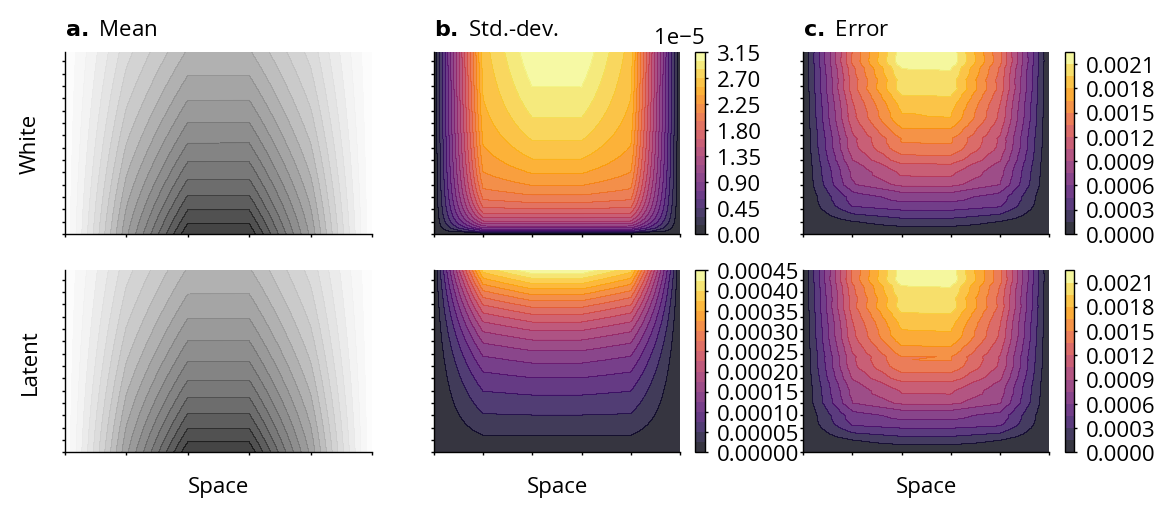

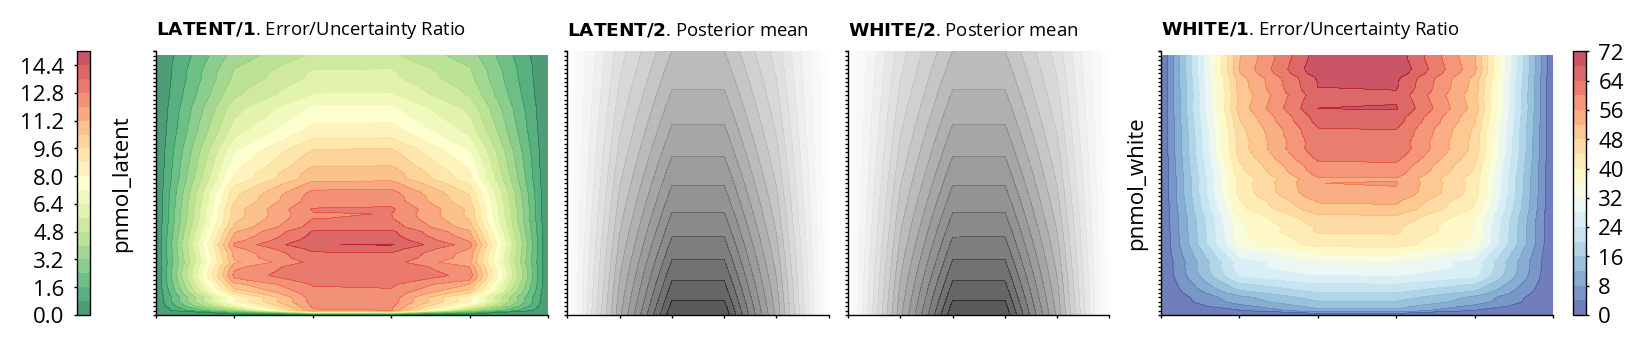

In [ ]:
!python3 experiments/figure1.py
from plotting import figure_1, figure_1_singlerow
figure_1()
figure_1_singlerow()

*Top:* Compairison between latent and white noise PNMOL on Burger's equation. As expected we can see in the plots above that the mean (a.) and error (c.) of both PNMOL versions are the same. Only the standard deviation is lower for the white noise PNMOL (b.), because it doesn't account for accumalitive uncertainties.

*Bottom:* Posterior means and error/uncertainty
ratios of latent PNMOL (left) and white noise PNMOL (right) on a fine time grid (y-axis) and a coarse
space grid (x-axis) for Burgers' equation. The higher the error/uncertainty ratio, the more overconfident the model is. As expected the error/uncertainty ratio is lower for latent PNMOL.

### Figure 2: Discretise the Laplacian with a local and global approximation

PDE: burgers
num_mesh_points: 20
num_trial_points: 20
input_scales: [2.  0.8 3.2]
nugget_cholesky_E: 1e-12
nugget_gram_matrix: 1e-12
symmetrize_cholesky_E: True
kernel_input_scale: 3.2
kernel_output_scale: 0.01
Best MLE input scale selected: 0.001
100% 9/9 [03:48<00:00, 25.44s/it]
1172802139.4510634
2.731848517739709e+17
8.735915998005978e+16
Figure(1350x520)


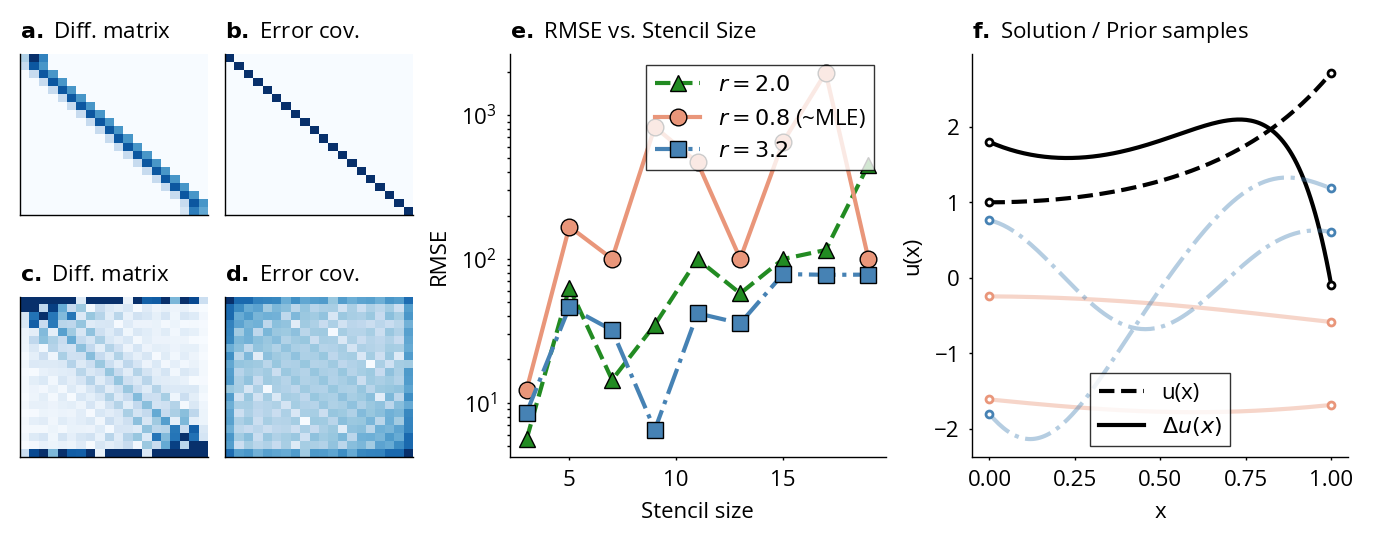

In [ ]:
!python3 experiments/figure2.py
from plotting import figure_2
figure_2()

Discretise the Laplacian with a local and global approximation: The target is the Laplacian $D = Δ$
of $u(x) = e^{x^2}$ (f).

*Left*: Sparsity pattern of the differentiation matrix and error covariance matrix for
the localised approximation (a, b) and the global approximation (c, d) on a mesh with N = 20 points. The
approximation is least certain at the boundaries.

*Center:* The root-mean-square error (RSME) between $\Delta u$ and its
approximation (e) increases with an increased stencil size.

*Right:* Samples from the prior GP
$u_x$ for both length scales are shown next to the solution and the target function (f).

### Figure 3: Spatial vs temporal discretisation error

experiments/results/figure3/
experiments/results/figure3/


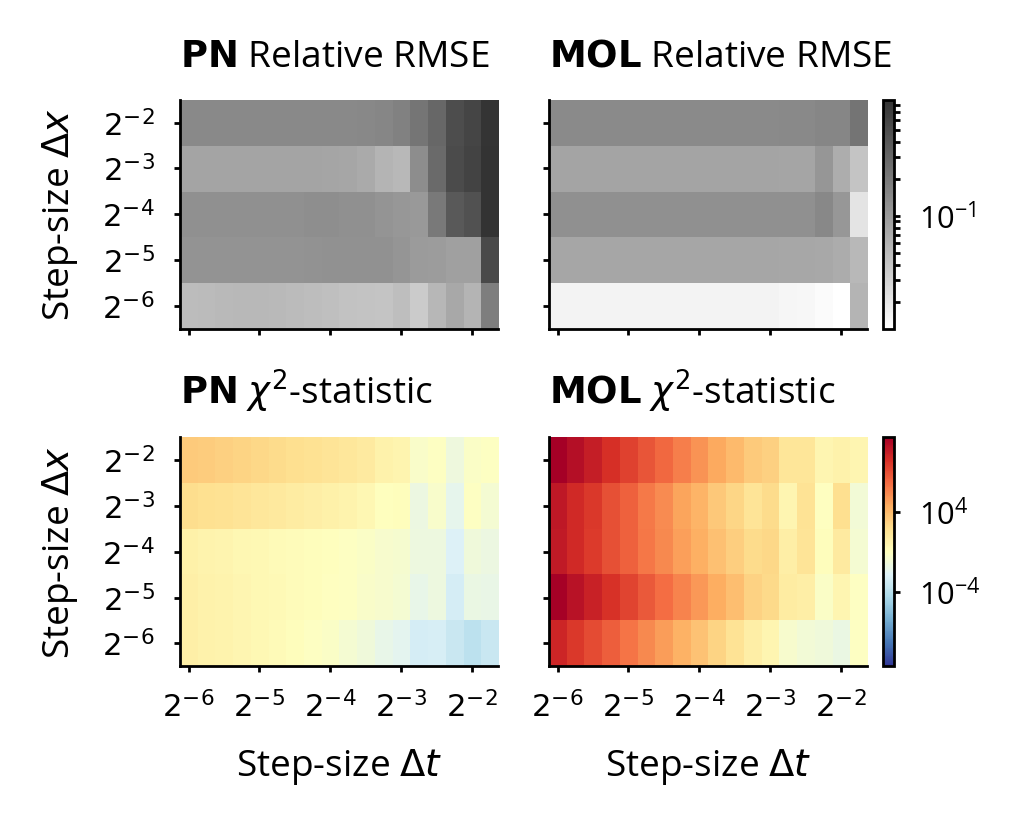

In [ ]:
# !python3 experiments/figure3.py
from plotting import figure_3_2x2
figure_3_2x2()

The relative RMSE is only small if both $\Delta t$ and $\Delta x$ are small, which affects all solvers: PNMOL (*top left*) as well as traditional
MOL combined with PN ODE solvers (*top right*). Traditional MOL is severely overconfident for large $\Delta x$ and
small $\Delta t$ (*bottom right*), while PNMOL delivers a
calibrated posterior distribution (*bottom left*).

### Figure 4: Quantify the global error

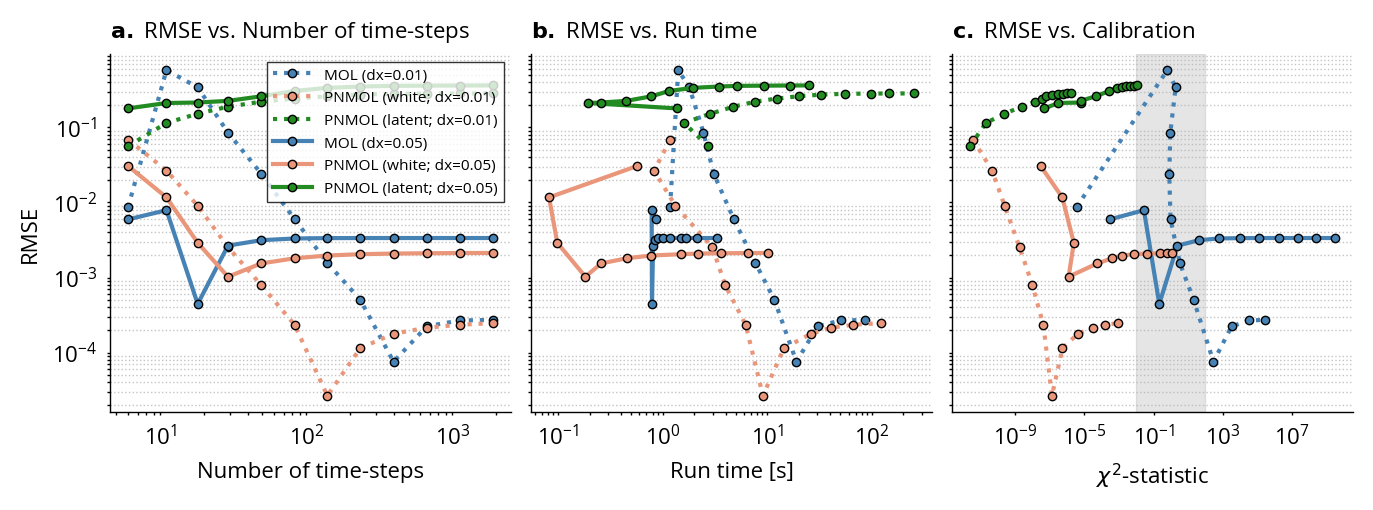

In [ ]:
# !python3 experiments/figure4.py
from plotting import figure_4
figure_4()

Work vs. precision vs. calibration of PNMOL in the latent-force version
(*green*) and the white-noise version (*orange*), compared to a traditional PN ODE solver combined with conventional
MOL (*blue*), on Burgers' equation.

The dotted curve is on a finer mesh ($dx = 0.01$) and the solid one on a coarser mesh ($dx = 0.05$). All methods perform better on a finer mesh in terms of RMSE.  White noise PNMOL performs best overall. The RMSE of MOL and white noise PNMOL is lower than the RMSE of latent PNMOL and stagnate after a certain accuracy is reached (left).

The run time of PNMOL-white is
comparable to that of MOL, and the run time of PNMOL-latent is slightly longer (middle).

The calibration of
PNMOL, measured in the normalised $\chi^2$-statistic of the Gaussian posterior (so that the "optimum" is 1, not d),
remains close to 1 but is slightly underconfident. With decreasing time-steps, MOL is poorly calibrated.
